# **DSC 190 – Statistical Analysis Notebook**

**Research Question 1**

> Is there a relationship between **location on campus (Zone)** and the **type of incident** reported?

**Research Question 2**

> Is there a statistically significant difference in the **number and type of incidents** across  
> (a) **day of week** and (b) **time of day** (late night vs early morning, etc.)?

This notebook focuses only on statistical analysis.

In [57]:
# !pip install openpyxl

In [58]:
# from google.colab import files
# import io
# uploaded = files.upload()
# print(uploaded.keys())
# filename = list(uploaded.keys())[0]
# print("Loaded file:", filename)

# df = pd.read_excel(io.BytesIO(uploaded[filename]))
# df.head()
# df.info()

## 1. Setup: mount drive, imports, load cleaned data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from scipy.stats import chi2 as chi2_dist
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import re

plt.rcParams['figure.figsize'] = (8, 4)

file_path = "/content/drive/MyDrive/DSC 190 Project/Cleaned CSV/df_clean_zones.xlsx"
df = pd.read_excel(file_path)

df.head()
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Incident type   2456 non-null   object        
 1   Location        2456 non-null   object        
 2   Date Reported   2456 non-null   datetime64[ns]
 3   Incident/Case#  2456 non-null   object        
 4   Date Occurred   2456 non-null   object        
 5   Time Occurred   2455 non-null   object        
 6   Summary         1211 non-null   object        
 7   Disposition     2456 non-null   object        
 8   Zone            2456 non-null   object        
 9   Polygon Zone    2456 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 192.0+ KB


## 2. Basic filtering and feature engineering

- Keep only **on-campus** incidents (drop "Off Campus" zone).
- Construct `datetime_occurred` from date and time columns.
- Derive `day_of_week`, `hour`, and a categorical `time_of_day`.

In [60]:
# Keep only on-campus incidents
if "Zone" in df.columns:
    df = df[df["Zone"] != "Off Campus"].copy()

# Parse datetime
df["datetime_occurred"] = pd.to_datetime(
    df["Date Occurred"].astype(str) + " " + df["Time Occurred"].astype(str),
    errors="coerce"
)

# Day of week and hour
df["day_of_week"] = df["datetime_occurred"].dt.day_name()
df["hour"] = df["datetime_occurred"].dt.hour

# Time-of-day bins
def time_of_day_from_hour(h):
    if pd.isna(h):
        return np.nan
    h = int(h)
    if 0 <= h < 6:
        return "Late Night (12–6am)"
    elif 6 <= h < 12:
        return "Morning (6am–12pm)"
    elif 12 <= h < 18:
        return "Afternoon (12–6pm)"
    else:
        return "Evening (6pm–12am)"

df["time_of_day"] = df["hour"].apply(time_of_day_from_hour)

print(df["day_of_week"].value_counts())
print(df["time_of_day"].value_counts())
print(df["Zone"].value_counts())

/tmp/ipython-input-4098340840.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["datetime_occurred"] = pd.to_datetime(


day_of_week
Friday       250
Thursday     232
Wednesday    224
Monday       197
Saturday     189
Tuesday      184
Sunday       150
Name: count, dtype: int64
time_of_day
Evening (6pm–12am)     482
Afternoon (12–6pm)     435
Morning (6am–12pm)     288
Late Night (12–6am)    221
Name: count, dtype: int64
Zone
Main        390
Med         214
Sixth       173
Marshall    159
Warren      137
Revelle     100
Muir         85
Eighth       77
ERC          58
Seventh      48
Name: count, dtype: int64


## 3. RQ1 – Location vs Incident Type

### 3.1 Top incident types by Zone (chi-square test + stacked bar)

Here we restrict to the **top 10 incident types** and test whether incident type depends on Zone.

In [61]:
# Top N incident types
N_TOP = 10
top_types = df["Incident type"].value_counts().head(N_TOP).index
df_top = df[df["Incident type"].isin(top_types)].copy()

# Contingency table: Incident type × Zone
ct_loc_type = pd.crosstab(df_top["Incident type"], df_top["Zone"])
print(ct_loc_type)

chi2, p, dof, expected = chi2_contingency(ct_loc_type)
print("\nChi-square test: Incident type vs Zone")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4g}")

Zone                                     ERC  Eighth  Main  Marshall  Med  \
Incident type                                                               
Elevator Problem                           0       1    10        15    8   
Fire Alarm                                 4      17    13        12    9   
Incomplete/Accidental Landline 911 Call    1       4    29        25    7   
Incomplete/Accidental Wireless 911 Call    2       5    21         2    7   
Medical Aid                                5       4    19         6   47   
Noise Disturbance                         13       9    14        15    0   
Petty Theft - Micro Mobility Device        0       1    16         5    4   
Security Alarm                             0       0    21         5    2   
Suspicious Person                          3       2    22         3    6   
Welfare Check                              1       3    26         3   14   

Zone                                     Muir  Revelle  Seventh  Sixth  War

### Plot: Incident type distribution by Zone

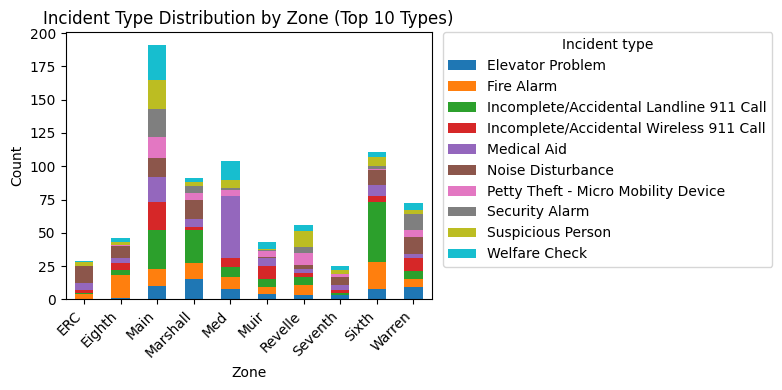

In [62]:
ax = ct_loc_type.T.plot(kind="bar", stacked=True)

ax.set_title("Incident Type Distribution by Zone (Top 10 Types)")
ax.set_ylabel("Count")
ax.set_xlabel("Zone")

plt.xticks(rotation=45, ha="right")

ax.legend(title="Incident type",
          bbox_to_anchor=(1.03, 1),
          loc="upper left",
          borderaxespad=0.)

plt.tight_layout()
plt.show()

### 3.2 Logistic regression: probability that an incident is theft, by Zone, day, and time

We create a binary indicator `is_theft` and fit a logistic regression:

\[
\text{logit}(\Pr(\text{theft})) = \beta_0 + \beta_{\text{Zone}} + \beta_{\text{day}} + \beta_{\text{time}}.
\]

In [63]:
df["is_theft"] = df["Incident type"].str.contains("theft", flags=re.IGNORECASE, na=False).astype(int)
print("Overall theft proportion:", df["is_theft"].mean())

# Drop rows missing predictors
model_df = df.dropna(subset=["is_theft", "Zone", "day_of_week", "time_of_day"]).copy()

# Logistic regression with categorical predictors
logit_model = smf.logit(
    "is_theft ~ C(Zone) + C(day_of_week) + C(time_of_day)",
    data=model_df
).fit()

print(logit_model.summary())

Overall theft proportion: 0.11242192921582235
Optimization terminated successfully.
         Current function value: 0.326409
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               is_theft   No. Observations:                 1426
Model:                          Logit   Df Residuals:                     1407
Method:                           MLE   Df Model:                           18
Date:                Sat, 06 Dec 2025   Pseudo R-squ.:                 0.07413
Time:                        07:14:37   Log-Likelihood:                -465.46
converged:                       True   LL-Null:                       -502.73
Covariance Type:            nonrobust   LLR p-value:                 7.613e-09
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercep

### 3.3 Petty theft proportion and confidence interval

We estimate the overall proportion of incidents that are **Petty Theft** and compute a 95% Wilson CI.

In [64]:
petty_mask = df["Incident type"].str.contains("Petty Theft", case=False, na=False)
n_total = len(df)
n_petty = petty_mask.sum()

prop_petty = n_petty / n_total
ci_low_petty, ci_high_petty = proportion_confint(
    count=n_petty, nobs=n_total, alpha=0.05, method="wilson"
)

print(f"Proportion of incidents that are petty theft: {prop_petty:.3f}")
print(f"95% CI (Wilson): [{ci_low_petty:.3f}, {ci_high_petty:.3f}]")

Proportion of incidents that are petty theft: 0.084
95% CI (Wilson): [0.071, 0.099]


### 3.4 Petty theft in Main Zone vs other Zones

We compare the proportion of petty theft incidents in **Main** vs **all other** zones,
with Wilson CIs and a z-test for difference in proportions.

In [65]:
main_mask = (df["Zone"] == "Main")
other_mask = (df["Zone"] != "Main")

n_main = main_mask.sum()
n_main_petty = (main_mask & petty_mask).sum()

n_other = other_mask.sum()
n_other_petty = (other_mask & petty_mask).sum()

print("\nMain Zone petty theft:")
print(f"{n_main_petty}/{n_main}")

print("Other Zones petty theft:")
print(f"{n_other_petty}/{n_other}")

ci_main = proportion_confint(n_main_petty, n_main, alpha=0.05, method="wilson")
ci_other = proportion_confint(n_other_petty, n_other, alpha=0.05, method="wilson")

print(f"95% CI (Main):  [{ci_main[0]:.3f}, {ci_main[1]:.3f}]")
print(f"95% CI (Other): [{ci_other[0]:.3f}, {ci_other[1]:.3f}]")

# Z-test and CI for difference
count = np.array([n_main_petty, n_other_petty])
nobs = np.array([n_main, n_other])

stat, pval = proportions_ztest(count, nobs)
ci_diff_low, ci_diff_high = confint_proportions_2indep(
    count1=n_main_petty, nobs1=n_main,
    count2=n_other_petty, nobs2=n_other,
    method="wald"
)

print("Z-test p-value:", pval)
print("95% CI for difference:", ci_diff_low, ci_diff_high)


Main Zone petty theft:
43/390
Other Zones petty theft:
78/1051
95% CI (Main):  [0.083, 0.145]
95% CI (Other): [0.060, 0.092]
Z-test p-value: 0.02839889015682053
95% CI for difference: 0.0011500859174391406 0.07093266799214634


## 4. RQ2 – Incident Counts by Day of Week and Time of Day

### 4.1 Incident counts by day of week (chi-square GOF)
We test whether incidents are uniformly distributed across days.

In [66]:
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_counts = df["day_of_week"].value_counts().reindex(dow_order)
print(dow_counts)

observed = dow_counts.values
expected = np.ones_like(observed) * observed.mean()

chi2_dow = ((observed - expected)**2 / expected).sum()
dof_dow = len(observed) - 1
p_dow = 1 - chi2_dist.cdf(chi2_dow, dof_dow)

print(f"\nChi-square GOF vs uniform:")
print(f"chi2 = {chi2_dow:.2f}, dof = {dof_dow}, p = {p_dow:.4g}")

day_of_week
Monday       197
Tuesday      184
Wednesday    224
Thursday     232
Friday       250
Saturday     189
Sunday       150
Name: count, dtype: int64

Chi-square GOF vs uniform:
chi2 = 33.82, dof = 6, p = 7.291e-06


### Plot: Incident counts by day of week

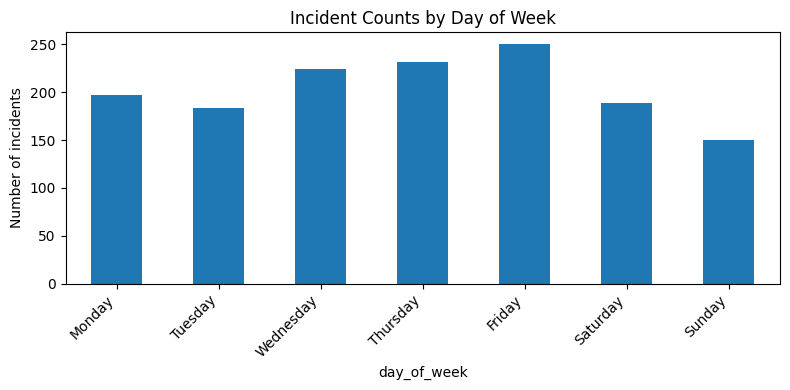

In [67]:
dow_counts.plot(kind="bar")
plt.title("Incident Counts by Day of Week")
plt.ylabel("Number of incidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 4.2 Incident counts by time of day
We summarize total incident counts within each time-of-day category.

time_of_day
Evening (6pm–12am)     482
Afternoon (12–6pm)     435
Morning (6am–12pm)     288
Late Night (12–6am)    221
Name: count, dtype: int64


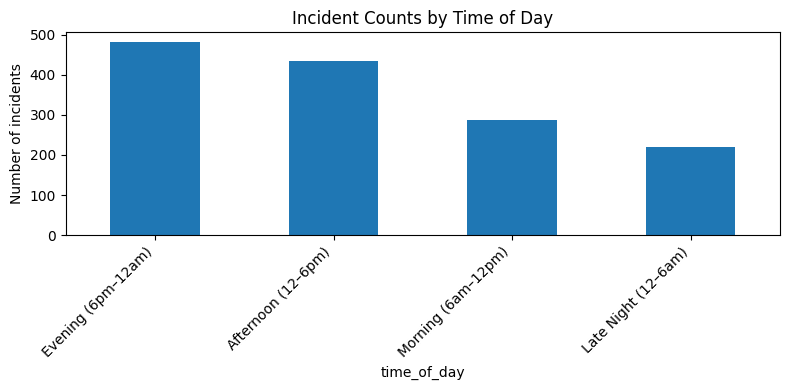

In [68]:
tod_counts = df["time_of_day"].value_counts()
print(tod_counts)

tod_counts.plot(kind="bar")
plt.title("Incident Counts by Time of Day")
plt.ylabel("Number of incidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 4.3 Hour-of-day line plot
Fine-grained view of incident counts by hour.

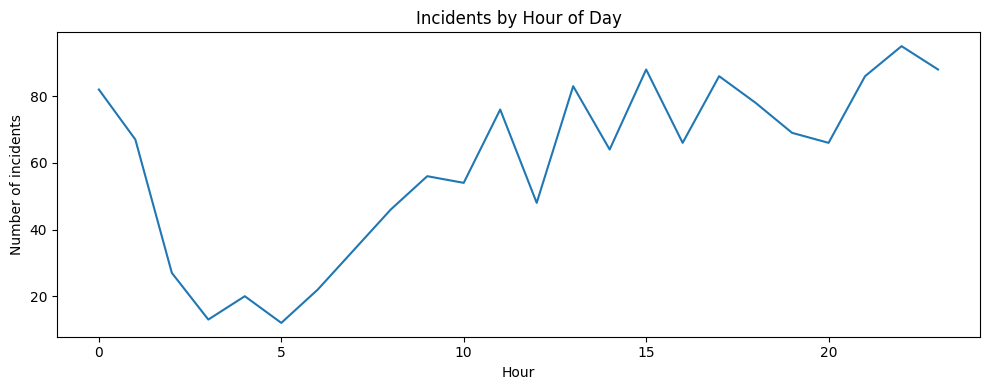

In [69]:
hourly = df.groupby(df["datetime_occurred"].dt.hour).size()
hourly.plot(kind="line", figsize=(10,4))
plt.title("Incidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of incidents")
plt.tight_layout()
plt.show()

## 5. Daily Aggregation and Two-Way ANOVA

We aggregate incidents to the **daily level**, keeping `day_of_week` and `time_of_day`.  
We then run a two-way ANOVA:

\[
\text{count} \sim \text{day_of_week} \times \text{time_of_day}.
\]

In [70]:
df["date_only"] = df["datetime_occurred"].dt.date

daily = df.groupby(["date_only", "day_of_week", "time_of_day"]).size().reset_index(name="count")

anova_model = smf.ols("count ~ C(day_of_week) * C(time_of_day)", data=daily).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                                    sum_sq     df          F        PR(>F)
C(day_of_week)                  164.288073    6.0   3.359121  3.225619e-03
C(time_of_day)                  355.093721    3.0  14.520871  7.573047e-09
C(day_of_week):C(time_of_day)   187.797539   18.0   1.279936  1.992668e-01
Residual                       2404.645704  295.0        NaN           NaN


### 5.1 Regression diagnostics for ANOVA model

We produce:
1. Predicted vs actual counts  
2. Histogram of residuals  
3. Normal Q–Q plot  
4. Residuals vs fitted values


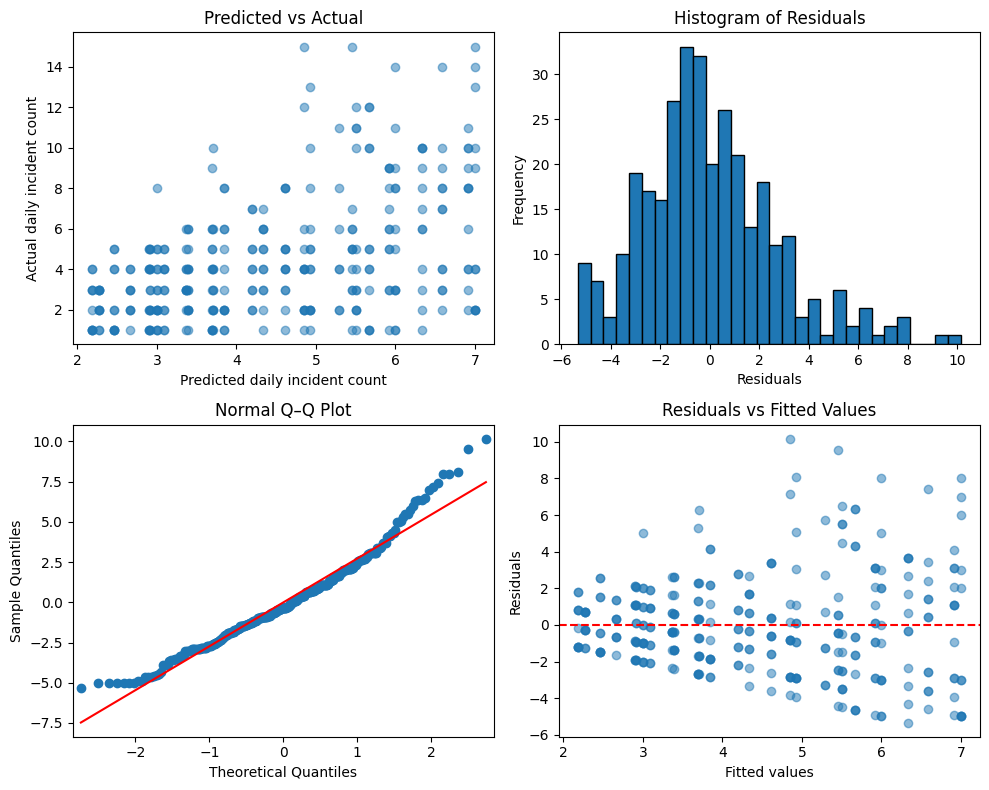

In [71]:
fitted = anova_model.fittedvalues
actual = daily["count"]
resid = anova_model.resid

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Predicted vs Actual
axes[0, 0].scatter(fitted, actual, alpha=0.5)
axes[0, 0].set_xlabel("Predicted daily incident count")
axes[0, 0].set_ylabel("Actual daily incident count")
axes[0, 0].set_title("Predicted vs Actual")

# Histogram of Residuals
axes[0, 1].hist(resid, bins=30, edgecolor="k")
axes[0, 1].set_xlabel("Residuals")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Histogram of Residuals")

# Normal Q–Q Plot
qqplot(resid, line="s", ax=axes[1, 0])
axes[1, 0].set_title("Normal Q–Q Plot")

# Residuals vs Fitted
axes[1, 1].scatter(fitted, resid, alpha=0.5)
axes[1, 1].axhline(0, color="red", linestyle="--")
axes[1, 1].set_xlabel("Fitted values")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title("Residuals vs Fitted Values")

plt.tight_layout()
plt.show()

### 5.2 Night vs day incident count ratio

We compare raw incident counts in **Evening + Late Night** vs **Morning + Afternoon**.

In [72]:
night = df["time_of_day"].isin(["Evening (6pm–12am)", "Late Night (12–6am)"])
day_mask = df["time_of_day"].isin(["Morning (6am–12pm)", "Afternoon (12–6pm)"])

n_night = night.sum()
n_day = day_mask.sum()

rate_ratio = n_night / n_day
print("Night-to-day incident count ratio =", rate_ratio)

Night-to-day incident count ratio = 0.9723374827109267


### 5.3 Approximate “relative risk” of a day having ≥1 night incident vs ≥1 day incident

We treat each day as “exposed” if it ever had a night incident, and compute an approximate
relative risk that a day with night incidents also has day incidents.

In [73]:
df["date_only"] = df["datetime_occurred"].dt.date

night = df["time_of_day"].isin(["Evening (6pm–12am)", "Late Night (12–6am)"])
day_mask = df["time_of_day"].isin(["Morning (6am–12pm)", "Afternoon (12–6pm)"])

day_level = df.groupby("date_only").agg(
    had_night_incident=("time_of_day", lambda s: (night[s.index]).any()),
    had_day_incident  =("time_of_day", lambda s: (day_mask[s.index]).any())
)

a = ((day_level["had_night_incident"]) & (day_level["had_day_incident"])).sum()
b = ((day_level["had_night_incident"]) & (~day_level["had_day_incident"])).sum()
c = ((~day_level["had_night_incident"]) & (day_level["had_day_incident"])).sum()
d = ((~day_level["had_night_incident"]) & (~day_level["had_day_incident"])).sum()

RR = (a / (a + b)) / (c / (c + d))
print("Approximate relative risk (>=1 incident on a day):", RR)

Approximate relative risk (>=1 incident on a day): 0.9545454545454546


## 6. Time-Series Properties of Daily Counts

### 6.1 ACF of daily incident counts (full period)

We look at autocorrelation in daily incident totals.

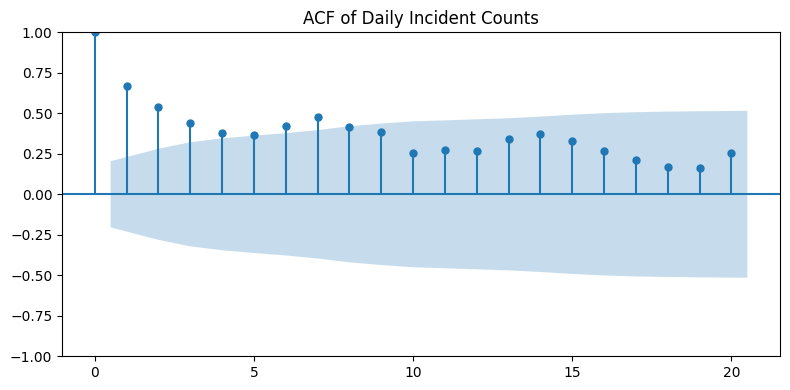

In [74]:
daily_counts_full = df.groupby(df["datetime_occurred"].dt.date).size()
plot_acf(daily_counts_full)
plt.title("ACF of Daily Incident Counts")
plt.tight_layout()
plt.show()

### 6.2 Restricted range (Aug 1 – Nov 3, 2025): daily counts and linear trend
We zoom in on one time window and fit a simple linear trend model.


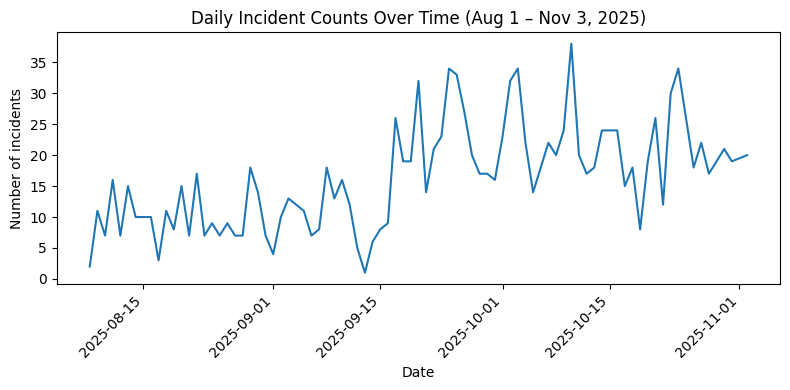

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     49.03
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           5.77e-10
Time:                        07:14:39   Log-Likelihood:                -284.10
No. Observations:                  86   AIC:                             572.2
Df Residuals:                      84   BIC:                             577.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7033      1.424      5.409      0.0

In [75]:
start_date = pd.to_datetime("2025-08-01")
end_date   = pd.to_datetime("2025-11-03")

mask = (df["datetime_occurred"] >= start_date) & (df["datetime_occurred"] <= end_date)
df_range = df.loc[mask].copy()

df_range["date_only"] = df_range["datetime_occurred"].dt.date
daily_counts_range = df_range.groupby("date_only").size()

daily_counts_range.plot()
plt.title("Daily Incident Counts Over Time (Aug 1 – Nov 3, 2025)")
plt.ylabel("Number of incidents")
plt.xlabel("Date")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

ts_df_range = daily_counts_range.reset_index(name="count").rename(columns={"date_only": "date"})
ts_df_range["t"] = np.arange(len(ts_df_range))

X_range = sm.add_constant(ts_df_range["t"])
y_range = ts_df_range["count"]
ts_model_range = sm.OLS(y_range, X_range).fit()
print(ts_model_range.summary())


### 6.3 Overall daily trend: scatter + regression line

We fit an OLS trend model on **all daily counts** and plot daily incidents vs time index with the fitted line.


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     70.56
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           6.07e-13
Time:                        07:14:39   Log-Likelihood:                -303.29
No. Observations:                  92   AIC:                             610.6
Df Residuals:                      90   BIC:                             615.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5806      1.367      4.082      0.0

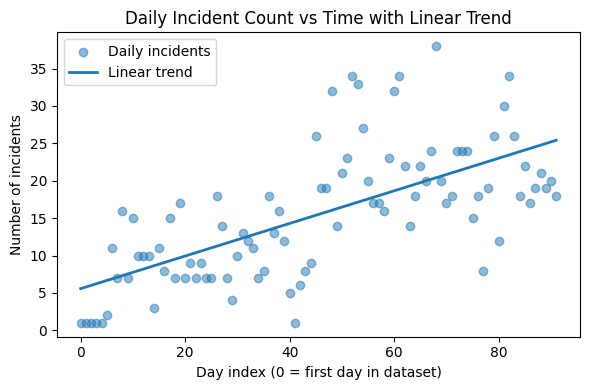

In [76]:
ts_df = (
    daily_counts_full
    .reset_index(name="count")
    .rename(columns={"datetime_occurred": "date"})
    .sort_values("date")
)

ts_df["t"] = np.arange(len(ts_df))   # 0,1,2,...

X = sm.add_constant(ts_df["t"])
y = ts_df["count"]
ts_model = sm.OLS(y, X).fit()
print(ts_model.summary())

plt.figure(figsize=(6, 4))
plt.scatter(ts_df["t"], ts_df["count"], alpha=0.5, label="Daily incidents")
plt.plot(ts_df["t"], ts_model.predict(X), linewidth=2, label="Linear trend")
plt.xlabel("Day index (0 = first day in dataset)")
plt.ylabel("Number of incidents")
plt.title("Daily Incident Count vs Time with Linear Trend")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Poisson Regression for Daily Counts

We use a Poisson GLM to model daily counts as a function of `day_of_week` and `time_of_day`.


In [77]:
poisson_model = smf.glm(
    "count ~ C(day_of_week) + C(time_of_day)",
    data=daily,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  323
Model:                            GLM   Df Residuals:                      313
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -768.18
Date:                Sat, 06 Dec 2025   Deviance:                       521.57
Time:                        07:14:39   Pearson chi2:                     556.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2961
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## 8. Categorical Associations Involving Incident Type

### 8.1 Incident type × day of week (chi-square)


In [78]:
ct_type_dow = pd.crosstab(df_top["Incident type"], df_top["day_of_week"])
print(ct_type_dow)

chi2, p, dof, expected = chi2_contingency(ct_type_dow)
print("\nChi-square test: Incident type vs Day of Week")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p = {p:.4g}")


day_of_week                              Friday  Monday  Saturday  Sunday  \
Incident type                                                               
Elevator Problem                             11       7         7       7   
Fire Alarm                                   15      17        15      12   
Incomplete/Accidental Landline 911 Call      37       5        24       9   
Incomplete/Accidental Wireless 911 Call       7      15         5       6   
Medical Aid                                  16      26         9      11   
Noise Disturbance                            10      12        13      13   
Petty Theft - Micro Mobility Device          10      12         1       2   
Security Alarm                                7       7         9       4   
Suspicious Person                             8      15         8       5   
Welfare Check                                14       8        13       7   

day_of_week                              Thursday  Tuesday  Wednesday  
Inc

### 8.2 Incident type × time of day (chi-square)


In [79]:
ct_type_tod = pd.crosstab(df_top["Incident type"], df_top["time_of_day"])
print(ct_type_tod)

chi2, p, dof, expected = chi2_contingency(ct_type_tod)
print("\nChi-square test: Incident type vs Time of Day")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p = {p:.4g}")


time_of_day                              Afternoon (12–6pm)  \
Incident type                                                 
Elevator Problem                                         27   
Fire Alarm                                               22   
Incomplete/Accidental Landline 911 Call                  66   
Incomplete/Accidental Wireless 911 Call                  33   
Medical Aid                                              38   
Noise Disturbance                                         0   
Petty Theft - Micro Mobility Device                      19   
Security Alarm                                            8   
Suspicious Person                                        10   
Welfare Check                                            16   

time_of_day                              Evening (6pm–12am)  \
Incident type                                                 
Elevator Problem                                         19   
Fire Alarm                                            

### 8.3 Time of day × day of week (chi-square + heatmap)
We test whether the distribution of time-of-day categories differs across days of the week.


In [80]:
ct = pd.crosstab(df["time_of_day"], df["day_of_week"])
chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square: ", chi2)
print("df:", dof)
print("p-value:", p)


Chi-square:  28.979307742035292
df: 18
p-value: 0.048632540662989665


### Plot: heatmap of incident density by day and time of day


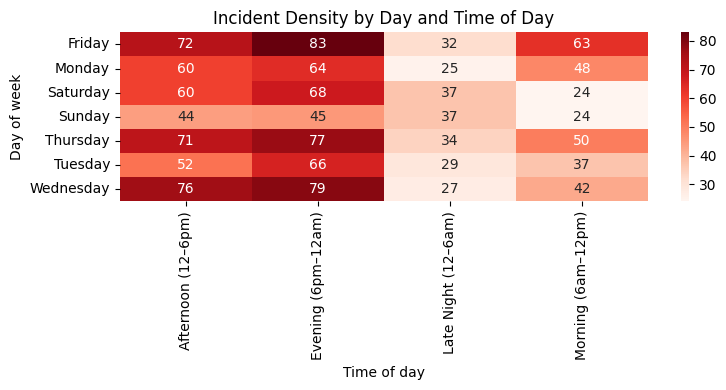

In [81]:
heat = pd.crosstab(df["day_of_week"], df["time_of_day"])
sns.heatmap(heat, annot=True, cmap="Reds")
plt.title("Incident Density by Day and Time of Day")
plt.xlabel("Time of day")
plt.ylabel("Day of week")
plt.tight_layout()
plt.show()

## 9. Mean daily incident rate and 95% CI

We compute the mean number of incidents per day and a normal-approximation CI.

In [82]:
daily_counts = df.groupby(df["datetime_occurred"].dt.date).size()
mean_daily = daily_counts.mean()
std_daily = daily_counts.std()
n_days = len(daily_counts)

ci_low = mean_daily - 1.96 * (std_daily / np.sqrt(n_days))
ci_high = mean_daily + 1.96 * (std_daily / np.sqrt(n_days))

print("Mean daily incidents:", mean_daily)
print("95% CI:", ci_low, ci_high)

Mean daily incidents: 15.5
95% CI: 13.70560851465585 17.29439148534415


## 10. Backward Elimination: Adjusted R² vs Steps

We compare nested OLS models for daily counts with different combinations of day-of-week and time-of-day effects:

1. Full interaction: `C(day_of_week) * C(time_of_day)`  
2. Main effects only: `C(day_of_week) + C(time_of_day)`  
3. Time of day only  
4. Day of week only


In [83]:
daily["day_of_week"] = daily["day_of_week"].astype("category")
daily["time_of_day"] = daily["time_of_day"].astype("category")

be_steps = [
    ("C(day_of_week) * C(time_of_day)", "Full: day × time interaction"),
    ("C(day_of_week) + C(time_of_day)", "Main effects only"),
    ("C(time_of_day)",                   "Time of day only"),
    ("C(day_of_week)",                   "Day of week only"),
]

be_results = []
for step, (rhs, label) in enumerate(be_steps, start=1):
    formula = f"count ~ {rhs}"
    model = smf.ols(formula, data=daily).fit()
    be_results.append({
        "Step": step,
        "Model": label,
        "Formula": formula,
        "Adj_R2": model.rsquared_adj,
    })

be_results_df = pd.DataFrame(be_results)
be_results_df

,Step,Model,Formula,Adj_R2
0,1,Full: day × time interaction,count ~ C(day_of_week) * C(time_of_day),0.148480
1,2,Main effects only,count ~ C(day_of_week) + C(time_of_day),0.134772
2,3,Time of day only,count ~ C(time_of_day),0.097246
3,4,Day of week only,count ~ C(day_of_week),0.025599


### Plot: Adjusted R² vs step

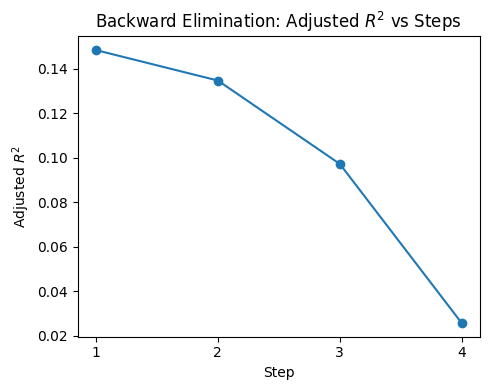

In [84]:
plt.figure(figsize=(5, 4))
plt.plot(be_results_df["Step"], be_results_df["Adj_R2"], marker="o")
plt.xlabel("Step")
plt.ylabel("Adjusted $R^2$")
plt.title("Backward Elimination: Adjusted $R^2$ vs Steps")
plt.xticks(be_results_df["Step"])
plt.tight_layout()
plt.show()